In [5]:
import pandas as pds, numpy as np, tensorflow as tf
import nltk, itertools
import matplotlib.pyplot as plt
from datasets import Dataset

In [6]:
#ensures the dataframe is 50% legit 50% phish:
def get5050(df):
    nPhish = len(df[df['label']==1])
    nLegit = len(df[df['label']==0])
    
    nMin = min(nPhish, nLegit)
    #select the nMin phish-rows
    sPhish = df[df['label']==1].sample(n=nMin)
    #select the nMin legit-rows
    sLegit = df[df['label']==0].sample(n=nMin)
    
    if(len(sPhish)!=len(sLegit)):
        print("Error laoding 50/50 dataset")
        
    return sLegit.append(sPhish,ignore_index=True)


def proc_urls(df, splitter):    
    if(not isinstance(splitter,nltk.tokenize.regexp.RegexpTokenizer)):
        raise TypeError("splitter of proc_url must be nltk RegexpTokenizer")
    
    if(procURL==False):
        return df
    
    newUrls = []
    for url in df["url"]:
        url = str(url).lower()

        url.encode('utf-8', 'ignore').decode()
        urlSplit = [clean.strip() for clean in splitter.tokenize(url) if(clean.strip()!="")]
    
        newUrls += " ".join(urlSplit)
    df["url"] = newUrls
    return df

In [7]:
def plot_confusion_matrix(cm, class_names, cTitle='Confusion Matrix'):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    NOTE: Modified from output of scikit learn!  
    EXPECTS: [[tp, fp],[fn,tn]]
    
    Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
    """
  
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(cTitle)
    #plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    #Normalize the confusion matrix.
    #cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    colm = np.array([["white","black"],["black","white"]])
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=colm[i,j])

    plt.tight_layout()
    plt.ylabel('Predicted')
    plt.xlabel('Truth')
  
    return figure

## Setup tokenizer

In [8]:
import transformers
from transformers import DataCollatorWithPadding,TFAutoModelForSequenceClassification, RobertaTokenizerFast, TFRobertaForSequenceClassification, TFTrainer, TFTrainingArguments, DistilBertTokenizer, TFDistilBertModel
from transformers import RobertaTokenizer, TFRobertaModel

checkpoint = "distilroberta-base"
tokenizer = RobertaTokenizer.from_pretrained(checkpoint)

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

##  Let's create/load a CSV into a dataset object:

In [9]:
from sklearn.model_selection import train_test_split

#load the csv:
dfTrain = pds.read_csv("../../data/compiled/allTrain.csv", index_col = 0)
dfTest = pds.read_csv("../../data/compiled/allTest.csv", index_col = 0)

splitter = nltk.RegexpTokenizer("\d+|[a-z]+|\W")
procURL=False

dfLegit = dfTrain[dfTrain["label"]==0]
dfPhish = dfTrain[dfTrain["label"]==1]


dfTrainFixed = get5050(dfTrain)
dfTestFixed = get5050(dfTest)

dfTrainFixed = proc_urls(dfTrainFixed,splitter)
dfTestFixed = proc_urls(dfTestFixed,splitter)

display((len(dfTrainFixed), len(dfTrain)))
display((len(dfTestFixed), len(dfTest)))

(24310, 60775)

(6078, 15195)

In [10]:
dfTrainFixed
#tf.data.Dataset.from_tensor_slices(dict(dfTrainFixed))

,label,url
0,0,appenninoacavallo.it/decking/48689-composite-w...
1,0,wiki.gps-tracker.com.ua/doku.php?id=gps-tracke...
2,0,olaf-kiessling.afd-thl.de/tag/auswirkungen/
3,0,www.ffss.fr/web/ffss/621-le-point-d-alerte-et-...
4,0,www.99.com.cn/baike/xq/1575.html
...,...,...
24305,1,storage.cloud.google.com/user7773578ixh1092839...
24306,1,movies-pictures.net/admin/att3/......
24307,1,combust-washing.000webhostapp.com/www/www/vbzone/
24308,1,docs.google.com/forms/d/e/1FAIpQLSe9VpsoDjFkAC...


In [11]:
TrainDataset = Dataset.from_pandas(dfTrainFixed)
TestDataset = Dataset.from_pandas(dfTestFixed)

In [12]:
TrainDataset,TestDataset

(Dataset({
     features: ['label', 'url'],
     num_rows: 24310
 }),
 Dataset({
     features: ['label', 'url'],
     num_rows: 6078
 }))

In [13]:
def tokenize_function(example):
    return tokenizer(example["url"], truncation=True)

tokenized_TrainDatasets = TrainDataset.map(tokenize_function, batched=True)
tokenized_TestDatasets = TestDataset.map(tokenize_function, batched=True)

  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

In [14]:
tokenized_TrainDatasets

Dataset({
    features: ['attention_mask', 'input_ids', 'label', 'url'],
    num_rows: 24310
})

In [15]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

tf_train_dataset = tokenized_TrainDatasets.to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["labels"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=128,
)

tf_validation_dataset = tokenized_TestDatasets.to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["labels"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=128,
)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

2021-11-30 02:57:45.414911: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-30 02:57:45.415099: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-30 02:57:45.423349: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## Fine tuning the model

In [16]:
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

Downloading:   0%|          | 0.00/465M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.optimizers import Adam

batch_size = 128
num_epochs = 2
# The number of training steps is the number of samples in the dataset, divided by the batch size then multiplied
# by the total number of epochs
num_train_steps = len(tf_train_dataset) * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps
)

opt = Adam(learning_rate=lr_scheduler)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])
model.fit(tf_train_dataset, validation_data=tf_validation_dataset, epochs=2)

Epoch 1/2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (o

2021-11-30 02:57:58.107283: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-30 02:57:58.118928: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3800135000 Hz


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

In [18]:
preds = model.predict(tf_validation_dataset)["logits"]

In [19]:
class_preds = np.argmax(preds, axis=1)

In [20]:
results = tokenized_TestDatasets["label"]
len(class_preds),len(tokenized_TestDatasets["label"])

(6078, 6078)

In [21]:
def plot_confusion_matrix(cm, class_names, cTitle='Confusion Matrix'):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    NOTE: Modified from output of scikit learn!  
    EXPECTS: [[tp, fp],[fn,tn]]
    
    Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
    """
  
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(cTitle)
    #plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    #Normalize the confusion matrix.
    #cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    colm = np.array([["white","black"],["black","white"]])
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=colm[i,j])

    plt.tight_layout()
    plt.ylabel('Predicted')
    plt.xlabel('Truth')
  
    return figure

## Confusion matrix

Training Bal Accuracy: 95.689%


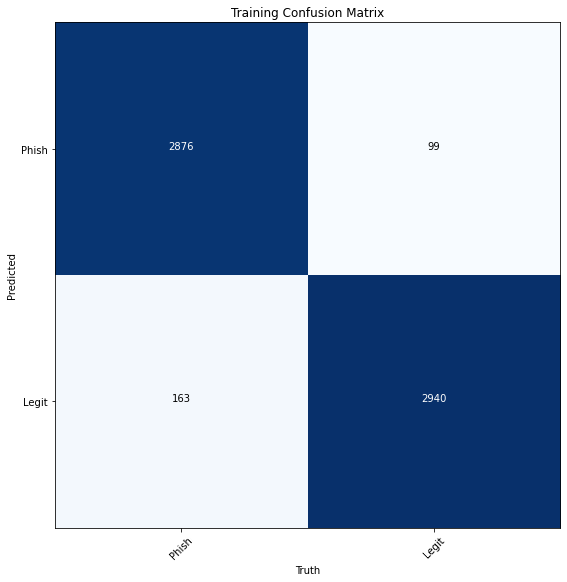

In [22]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(results, class_preds).ravel()
traccuracy = (tp + tn)/(tn + tp + fn + fp)
traccuracyB = ((tp/(tp+fn) + tn/(fp+tn))*0.5)
print("Training Bal Accuracy: {:.3f}%".format(traccuracyB*100.))
cmatrix = np.array([[tp, fp],[fn, tn]])
disp = plot_confusion_matrix(cmatrix, ['Phish','Legit'], cTitle='Training Confusion Matrix')

In [23]:
def evaluate(preds, results):
        confusion_matrix = np.zeros((2,2))
        for i in range(len(results)):
            confusion_matrix[preds[i]][results[i]]+=1
        # precision=TP/(TP+FP) recall f1 accuracy
        precision = 0 if confusion_matrix[1][1]+confusion_matrix[1][0]==0 else confusion_matrix[1][1]/(confusion_matrix[1][1]+confusion_matrix[1][0])
        recall = 0 if confusion_matrix[1][1]+confusion_matrix[0][1]==0 else confusion_matrix[1][1]/(confusion_matrix[1][1]+confusion_matrix[0][1])
        f1 = 0.0 if precision+recall==0 else 2*precision*recall/(precision+recall)
        accuracy = (confusion_matrix[0][0]+confusion_matrix[1][1])/np.sum(confusion_matrix)
        print("The precision is: {0}\nThe recall is: {1}\nThe f1 is: {2}\nThe accuracy is: {3}"
              .format(precision,recall,f1,accuracy))
        
        return None

In [24]:
evaluate(class_preds,results)

The precision is: 0.9667226890756303
The recall is: 0.9463639355051003
The f1 is: 0.9564349850349186
The accuracy is: 0.9568937150378414
